In [2]:
# Libraries

import sys
import math
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup as bs
import requests
from datetime import datetime, timedelta
import folium

In [138]:
# Inital information

url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-1?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'
# change page numbers for these!
html = requests.get(url)
soup = bs(html.text, 'html.parser')

body = soup.find('body')
header = body.find('div', class_ = 'results-header mt-5')
property_count = int(header.find('div', class_ = 'results-message').contents[0].strip())
pages_needed = math.ceil(property_count / 24) + 1
# extra pages only include featured properties - so doesn't go past max. page index.

print(f"There are {property_count} properties on the website currently.\nSo {pages_needed} pages are needed.")

There are 65 properties on the website currently.
So 4 pages are needed.


In [139]:
# Function for getting links

def get_links(soup):
    links = []

    i = 1
    max_iterations = 30
    while len(links) < 24 and i <= max_iterations:
        elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--results > a")
        # Featured properties still appear elsewhere - so aren't needed. It also causes a break when an empty page is reached.

        # if not elements:
        #     elements = soup.select(f"body > div.container.mt-3 > div.results.row > div:nth-child({i}) > div.card.h-100.card--featured > a")

        if not elements:
            i += 1
            continue

        for element in elements:
            href = element['href']
            link = 'https://propertylink.estatesgazette.com'+ href
            links.append(link)
        i += 1

    return links


all_links = get_links(soup)


In [140]:
# Looping through pages

base_url = 'https://propertylink.estatesgazette.com/commercial-property-for-rent/bath/page-{}?filters%5Bnot_property_states%5D%5B%5D=Under+Offer&filters%5Bto_let_price%5D%5Bcurrency%5D=gbp&filters%5Bto_let_price%5D%5Bfrom%5D=&filters%5Bto_let_price%5D%5Bsize_modifier%5D=sqft&filters%5Bto_let_price%5D%5Bto%5D=&search=Bath&sort_direction=desc&sort_field=created_at&view=grid'

all_links = []  # Store all links from all pages

for page_num in range(1, pages_needed+1):  # Loop over the page numbers (1 to 3 in this example)
    url = base_url.format(page_num)
    html = requests.get(url)
    soup = bs(html.text, 'html.parser')
    
    page_links = get_links(soup)
    all_links.extend(page_links)  # Add the links from this page to the all_links list

    print(f"Page {page_num} has {len(page_links)} links.")

property_links = list(set(all_links)) # removing duplicates
print(f"Total links collected: {len(property_links)}")


Page 1 has 24 links.
Page 2 has 24 links.
Page 3 has 17 links.
Page 4 has 0 links.
Total links collected: 65


In [141]:
# Single property test

single_link = property_links[2]
print(single_link)

html = requests.get(single_link)
soup = bs(html.text, 'html.parser')

# soup.select('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-name')
agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()


agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > img')
if agency_name == None:
    agency_name = soup.select_one('body > div.details-section.details-agent-contacts > div > div > div > div.col-md-4.col-12 > div.agent-logo > a > img')
agency_name = agency_name['alt']

agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
agency_name = agency_name.get("content")



id_tag = soup.find("meta", {"name": "gwa_contentID"})
id_tag = id_tag.get("content")

# address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(3)') # Full div
# address = address[0].get_text(strip=True) # gives address with below stuck to the front
# address = address.replace("ADDRESS", "").strip() #tidy

address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
address = address[0].get_text(strip=True)
address = address.replace("sharebookmark", "").strip() #tidy

size = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(2)')
size = size[0].get_text(strip=True) # gives size with below stuck to the front
size = size.replace("SIZE", "").strip() #tidy

type = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(4)')
type = type[0].get_text(strip=True)
type = type.replace("TYPE", "").strip()

price = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(1)')
price = price[0].get_text(strip=True)
price = price.replace("TO RENT", "").strip()

date_posted = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div:nth-child(6)')
date_posted = date_posted[0].get_text(strip=True)
date_posted = date_posted.replace("POSTED ON", "").strip()

desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
desc = desc.get_text(strip=True)

latitude = soup.find('meta', itemprop='latitude')['content']
longitude = soup.find('meta', itemprop='longitude')['content']

print(agent_name)
print(agency_name)
print(id_tag)
print(address)
print(size)
print(type)
print(price)
print(date_posted)
print(desc,'\n')
print(latitude, ',', longitude)



https://propertylink.estatesgazette.com/property-details/6961142-bellotts-road-bath-somerset-ba2-3rt
Emily Dagg
CSquared (Previously Colston & Colston Chartered Surveyors)
6961142
Bellotts Road, Bath, Somerset, BA2 3RT
2,147 - 5,003 Sq Ft
General Industrial, Industrial
£10.00   Per Sq Ft
21st May 2024
DescriptionThe plot comprises x2 steel framed buildings (interconnected) with block elevations beneath a single skin corrugated fibre cement (part asbestos) sheet roof with c.5% skylights. Concrete floor. Pressed steel windows. Fibre cement rainwater goods. The eaves height is c.7.9m max, 6m min with level access loading bay in north gable with roller shutter door (h 5.2m). Separate pedestrian door. In the warehouse there is strip lighting with corrugated light panels in the roof and to the rear elevation. The office areas are fitted to an basic specification. The 2 buildings are constructed at an angle from each other which has been infilled to provide WC and side stores, which are share

In [142]:
# Collecting all property information

def assign_value(elements, keyword):
    for element in elements:
        text = element.get_text(strip=True)
        if keyword in text:
            return text.replace(keyword, "").strip()
    return None

property_data = []

for property in property_links:
    # print(property)
    html = requests.get(property)
    soup = bs(html.text, 'html.parser')

    agent_name = soup.find('div', class_='agent-name').find_all_next(string=True)[1].strip()
    
    agency_name = soup.find("meta", {"name": "gwa_advertiserName"})
    agency_name = agency_name.get("content")

    id_tag = soup.find("meta", {"name": "gwa_contentID"})
    id_tag = id_tag.get("content")

    desc = soup.select_one('body > div:nth-of-type(4) > div:nth-of-type(2) > div > div:nth-of-type(5) > div > div:nth-of-type(1)')
    desc = desc.get_text(strip=True)

    # address = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > h1')
    # address = address[0].get_text(strip=True)
    # address = address.replace("sharebookmark", "").strip() #tidy

    elements = soup.select('body > div.wrapper > div.container-wrapper.bg-white > div > div:nth-child(5) > div.details-section-body.row > div')

    # Assign values based on keywords - thank you ChatGPT for this one...
    price = assign_value(elements, "TO RENT")
    size = assign_value(elements, "SIZE")
    address = assign_value(elements, "ADDRESS")
    type = assign_value(elements, "TYPE")
    # tenure = assign_value(elements, "TENURE")
    date_posted = assign_value(elements, "POSTED ON")

    latitude = soup.find('meta', itemprop='latitude')['content']
    longitude = soup.find('meta', itemprop='longitude')['content']
    

    property_data.append({
        'Id': id_tag,
        'Address': address,
        'Price': price,
        'Size': size,
        'Property Type': type,
        'Agency Name': agency_name,
        'Agent Name': agent_name,
        'Description': desc,
        'Property Link': property,
        'Date Posted': date_posted,
        'Latitude': latitude,
        'Longitude': longitude
    })

    

df = pd.DataFrame(property_data)



df.head(2)

,Id,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude
0,6964228,"First Floor Offices, Bath Cricket Club, North Parade, Bath","£40,500.00 Per Annum","1,620 Sq Ft","Office, Offices",Carter Jonas LLP,Philip Marshall,"DescriptionOpen Plan Quality Offices / StudioNewley built, the offices provide open plan offices...",https://propertylink.estatesgazette.com/property-details/6964228-first-floor-offices-bath-cricke...,5th June 2024,51.3799994,-2.3527256
1,6984865,"Second Floor Front Suite, Redbridge House, Lower Bristol Road, Bath, Somerset","£29,500.00 Per Annum","2,052 Sq Ft","Office, Offices",Carter Jonas LLP,Philip Marshall,Part Open-Plan + Private OfficesThe building benefits from the following:- Passenger lift- New L...,https://propertylink.estatesgazette.com/property-details/6984865-second-floor-front-suite-redbri...,15th October 2024,51.381776,-2.377124


In [143]:
# Writing to csv
today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
df.to_csv(f'EG_scraped_{today}.csv', index=False, sep=',', encoding='utf-8-sig', header=True, quotechar='"')

In [ ]:
# Comparison w/ last week & writing changes to xlsx


today = datetime.now()
last_week = today - timedelta(weeks=1)
today = today.strftime("%d.%m.%y")
last_week = last_week.strftime("%d.%m.%y")
print(today)
df_old = pd.read_csv(f'EG_scraped_{last_week}.csv')
# df_old = pd.read_csv(f'EG_scraped_26.11.24.csv')
df_new = pd.read_csv(f'EG_scraped_{today}.csv') 
# df_new = pd.read_csv(f'EG_scraped_02.12.24.csv')

df_old.head()

key = 'Id'
df_dropped = df_old[~df_old[key].isin(df_new[key])]
# df_dropped.head()
# df_dropped.to_csv('dropped_5.11.24.csv', index=False)

df_posted = df_new[~df_new[key].isin(df_old[key])]
# df_posted.info()
# df_posted.head()
# df_posted.to_csv('posted_5.11.24.csv', index=False)



df_posted['Status'] = 'Added'
df_dropped['Status'] = 'Dropped'

df_dropped.head()

df_changes = pd.concat([df_posted, df_dropped], ignore_index=True)
df_changes = df_changes[['Status'] + [ col for col in df_changes.columns if col != 'Status' ]]
df_changes.head()


emails = pd.read_csv('emails.csv')
emails['Agent Name'] = emails['Forename'] + ' ' + emails['Surname']#
df_changes = pd.merge(df_changes, emails[['Agent Name', 'Email']], on='Agent Name', how='left')


df_changes.to_csv(f'changes_{today}.csv', index=False)
df_changes.to_excel(f'EGPL_changes_{today}.xlsx', index=False, engine='openpyxl')

02.12.24


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_12692\2875658969.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_posted['Status'] = 'Added'
C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_12692\2875658969.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dropped['Status'] = 'Dropped'


In [19]:
#Splitting Names into first and last

df_changes['Agent Name']
df_changes[['First Name', 'Last Name']] = df_changes['Agent Name'].str.split(' ', n=1, expand=True)
df_changes.head()

,Status,Id,Address,Price,Size,Property Type,Agency Name,Agent Name,Description,Property Link,Date Posted,Latitude,Longitude,Email,First Name,Last Name
0,Added,6993201,"7a Northumberland Buildings, Bath, BA1 2JE",ROA,"1,131 Sq Ft","Office, Offices",Savills - Industrial,Sam Williams,"Key PointsSelf contained offices - 1,131 sq ft.The property is overlooking the prestigious Queen...",https://propertylink.estatesgazette.com/property-details/6993201-7a-northumberland-buildings-ba1,29th November 2024,51.390838,-2.354562,sam.j.williams@savills.com,Sam,Williams
1,Dropped,6976767,"UBC Flexible Offices 4 Queen Street, Bath BA1 1HE","£400.00 - £6,500.00 Per Month",80 - 650 Sq Ft,"Office, Serviced Office, Offices",UBC UK,Camilla Fanegladwin,"Located in the heart of Bath, UBC Flexible offices at Queen Street, flexible office space offers...",https://propertylink.estatesgazette.com/property-details/6976767-flexible-offices-4-queen-street...,27th August 2024,51.382927,-2.361857,NaN,Camilla,Fanegladwin
2,Dropped,6738357,"Pinesgate East, Lower Bristol Road, Bath, Somerset, BA2 3DP","£393,328.00 Per Annum","15,130 Sq Ft","Office, Offices",CSquared (Previously Colston & Colston Chartered Surveyors),Richard Ford,DescriptionThe available suite comprises the entire first floor of Pinesgate East Building and p...,https://propertylink.estatesgazette.com/property-details/6738357-pinesgate-east-lower-bristol-ro...,8th August 2024,51.380243,-2.371123,richard.ford@cs-re.co.uk,Richard,Ford
3,Dropped,6990240,"2nd & 3rd Floors, Northgate House, Upper Borough Walls, Bath, United Kingdom BA1 1RG",ROA,"1 - 10,800 Sq Ft","Office, Serviced Office, Offices, Business park, Land, Retail, Commercial Land",IWG Plc,IWG PLC,"Being based in Bath gives your business the kudos of an historic, upmarket location among a rang...",https://propertylink.estatesgazette.com/property-details/6990240-we-offer-workspace-options-full...,13th November 2024,51.382617,-2.359545,NaN,IWG,PLC
4,Dropped,6979304,"Ground Floor Of 6 Westgate Buildings, Bath, Bath, Somerset","£50,000.00 Per Annum","1,012 Sq Ft","General Retail, Retail",Carter Jonas LLP,Tim Brooksbank,The property is arranged over ground floor only and consists of open plan sales space fronting o...,https://propertylink.estatesgazette.com/property-details/6979304-ground-floor-of-6-westgate-buil...,11th September 2024,51.382513,-2.381934,tim.brooksbank@carterjonas.co.uk,Tim,Brooksbank


In [20]:
# Making the map of all instructions

x = 0
df = pd.read_csv('EG_scraped_26.11.24.csv')
# df_cs = df[df['Agency Name'].str.contains('CSquared', case=False, na=False)]

map = folium.Map(location=(51.38, -2.36), zoom_start=10)#location - the center of the map, zoom_start - the resolution
for index, row in df.iterrows():

    popup_content = f"""
    <b>Id:</b> {row['Id']}<br>
    <b>Address:</b> {row['Address']}<br>
    <b>Price:</b> {row['Price']}<br>
    <b>Size:</b> {row['Size']}<br>
    <b>Property Type:</b> {row['Property Type']}<br>
    <b>Agency Name:</b> {row['Agency Name']}<br>
    <b>Agent Name:</b> {row['Agent Name']}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row['Property Link']}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row['Date Posted']}
    """

    if row['Agency Name'].lower().find('csquared') != -1:  # Check for CSquared
        colour = '#E7482A'  # CSquared orange
    else:
        colour = 'darkblue' # #212C52 is the colour I want, but can't get it to work - apparently folium icons don't work well with Hex codes consistently

    x += 1
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color=colour)
    ).add_to(map)

print(f'There are {x} properties under CSquared instruction in Bath.')
map # unhash this to get map


There are 70 properties under CSquared instruction in Bath.


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_12692\628564110.py:32: UserWarning: color argument of Icon should be one of: {'beige', 'cadetblue', 'darkblue', 'blue', 'red', 'pink', 'purple', 'lightgreen', 'lightred', 'orange', 'white', 'darkgreen', 'lightblue', 'lightgray', 'darkpurple', 'green', 'black', 'gray', 'darkred'}.
  icon=folium.Icon(color=colour)


In [21]:
# Making the map of CSquared instructions

x = 0
df = pd.read_csv('EG_scraped_26.11.24.csv')
df_cs = df[df['Agency Name'].str.contains('CSquared', case=False, na=False)]

map = folium.Map(location=(51.38, -2.36), zoom_start=10)#location - the center of the map, zoom_start - the resolution
for index, row in df_cs.iterrows():

    popup_content = f"""
    <b>Id:</b> {row['Id']}<br>
    <b>Address:</b> {row['Address']}<br>
    <b>Price:</b> {row['Price']}<br>
    <b>Size:</b> {row['Size']}<br>
    <b>Property Type:</b> {row['Property Type']}<br>
    <b>Agency Name:</b> {row['Agency Name']}<br>
    <b>Agent Name:</b> {row['Agent Name']}<br>
    <b>Description:</b> {row['Description'][:200]}...<br>
    <b>Property Link:</b> <a href="{row['Property Link']}" target="_blank">Link</a><br>
    <b>Date Posted:</b> {row['Date Posted']}
    """

    x += 1
    folium.Marker(
        location=(row['Latitude'], row['Longitude']),
        popup=folium.Popup(popup_content, max_width=1000),
        icon=folium.Icon(color='#E7482A') # CSquared orange
    ).add_to(map)

print(f'There are {x} properties under CSquared instruction in Bath.')
map # unhash this to get map

There are 28 properties under CSquared instruction in Bath.


C:\Users\GuyAnderson\AppData\Local\Temp\ipykernel_12692\1589361543.py:27: UserWarning: color argument of Icon should be one of: {'beige', 'cadetblue', 'darkblue', 'blue', 'red', 'pink', 'purple', 'lightgreen', 'lightred', 'orange', 'white', 'darkgreen', 'lightblue', 'lightgray', 'darkpurple', 'green', 'black', 'gray', 'darkred'}.
  icon=folium.Icon(color='#E7482A') # CSquared orange


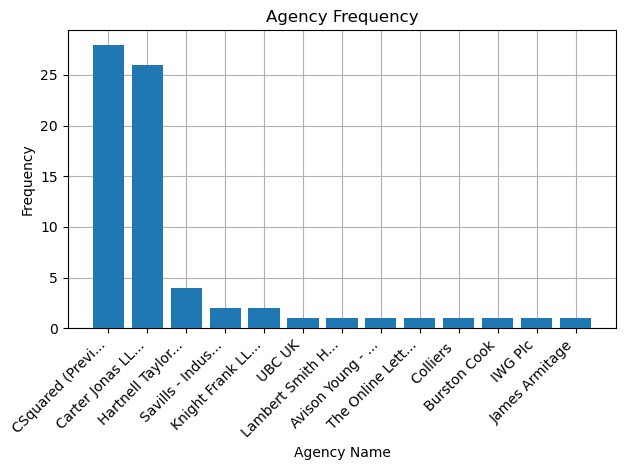

In [22]:
# Plotting bar graph by agency

import matplotlib.pyplot as plt

max_length = 15  # Adjust this value as needed

# Count occurrences of each unique category in 'Agency Name'
counts = df['Agency Name'].value_counts()

# Count occurrences of each unique category in 'Agency Name'
categories = df['Agency Name'].value_counts().index  # Unique categories
values = df['Agency Name'].value_counts().values     # Corresponding counts


categories = [name[:max_length] + '...' if len(name) > max_length else name for name in counts.index]
# Create a bar chart
plt.bar(categories, values, zorder=3)

# Add title and labels
plt.title('Agency Frequency')
plt.xlabel('Agency Name')
plt.ylabel('Frequency')
plt.grid(True, zorder=0)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Email draft - only if dropped - ACTUALLY DOES MAILTO NOW

for index in df_changes.index:
    if df_changes.loc[index, 'Status'] == 'Dropped':
# pd.set_option('display.max_colwidth', None)
        pd.set_option('display.max_colwidth', 100)

        email_body = f"""Hi {df_changes.iloc[index]['First Name']},\n 
I see that {df_changes.iloc[index]['Address']} has been taken off the wesbites. Please could you let me know the tenant, rent and lease length?\n
Thanks,\n"""
        # text like this doesnt need to be indented for some reason.

        my_email = ''
        my_password = ''
        if not pd.isna(df_changes.iloc[index]['Email']):
            email_address = df_changes.iloc[index]['Email']
            # print(f'mailto:{email_address}')
            import webbrowser
            address = df_changes.iloc[index]['Address']
            subject = address[:30] + '...' 

            body = email_body.replace(' ', '%20').replace('\n','%0A')

            webbrowser.open('mailto:?to=' + email_address + '&subject=' + subject + '&body=' + body, new=1)
        
        else:
            print('No email address found.')
        
        # print(email_body)

        print(f"\n\n\n {df_changes.iloc[index]}")
# How do I get this to send itself... do I need admin access 

No email address found.



 Status                                                                                                       Dropped
Id                                                                                                           6976767
Address                                                            UBC Flexible Offices 4 Queen Street, Bath BA1 1HE
Price                                                                                £400.00 - £6,500.00   Per Month
Size                                                                                                  80 - 650 Sq Ft
Property Type                                                                       Office, Serviced Office, Offices
Agency Name                                                                                                   UBC UK
Agent Name                                                                                       Camilla Fanegladwin
Description      Located in the hear

In [40]:
import webbrowser
one_row = df_changes.iloc[0]
address = one_row['Address']
subject = address[:10] + '...' 

body = email_body.replace(' ', '%20').replace('\n','%0A')

webbrowser.open('mailto:?to=' + email_address + '&subject=' + subject + '&body=' + body, new=1)

True